# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [70]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import ompy as om
import logging
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


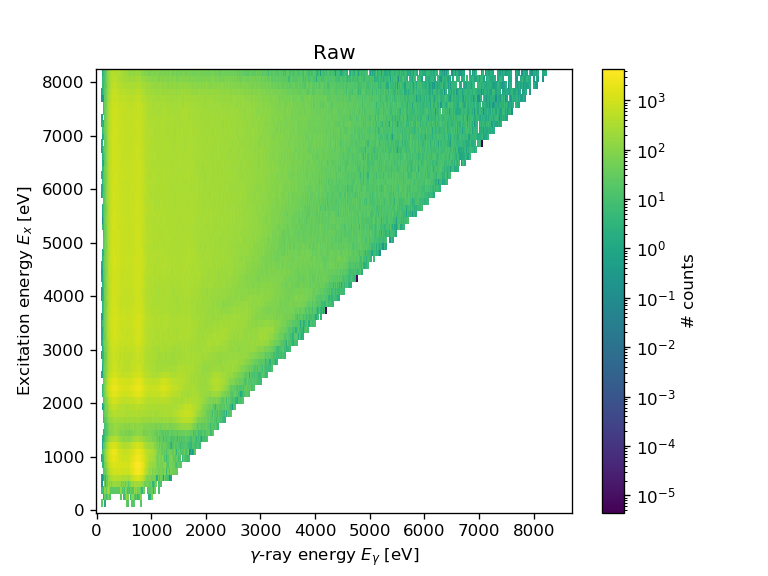

In [71]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.load_example_raw('Dy164')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut(axis='Ex', limits=[0, 8400])
raw.plot()

<IPython.core.display.Javascript object>


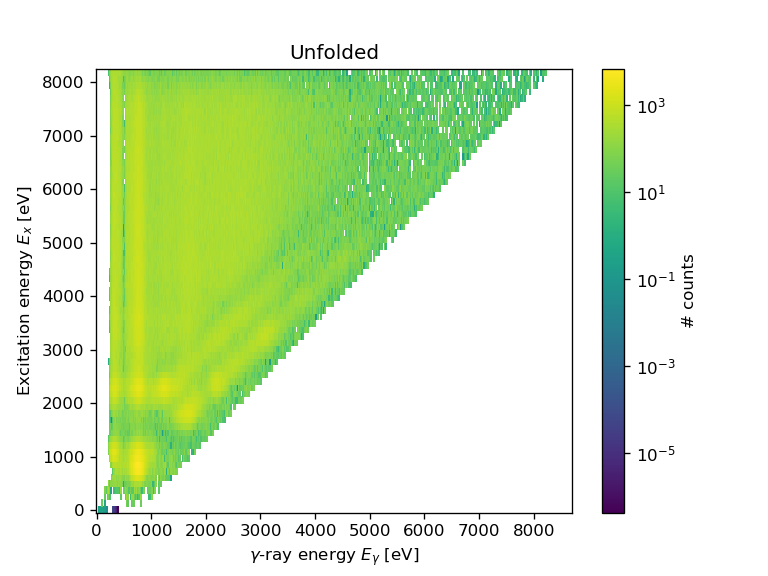

In [62]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "../data/Dy164_response_matrix.m"
fname_resp_dat = "../data/Dy164_response_parameters.dat"

unfolder = om.Unfolder()
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)
unfolded.plot()

<IPython.core.display.Javascript object>


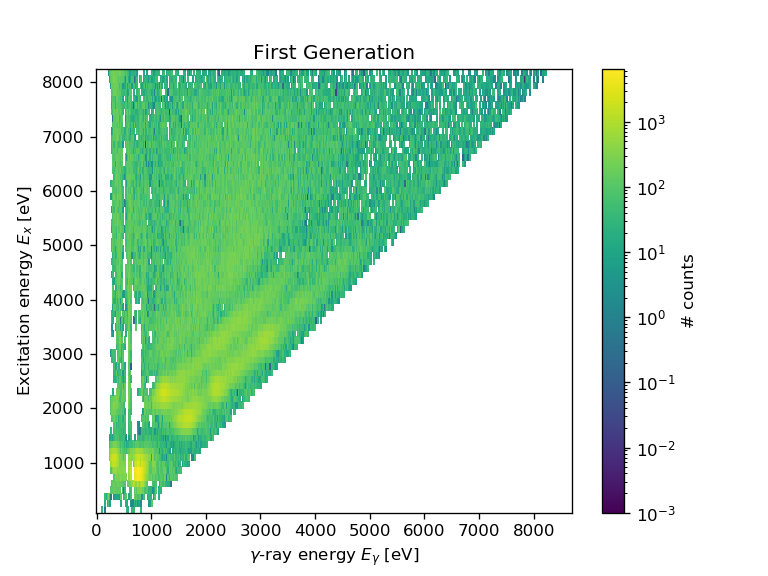

In [64]:
firstgen = om.first_generation_method(unfolded, Ex_max=8500, dE_gamma=500)
firstgen.plot(zmin=1e-3)

In [65]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=8500,
                                     dE_gamma=800,multiplicity_estimation="statistical")

ensemble = om.Ensemble(raw=raw, save_path="error_ensemble")
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=10, regenerate=True)


INFO:ompy.ensemble:Generating raw ensemble 0
INFO:ompy.ensemble:Unfolding raw 0
  fluctuations /= self.fluctuations(self.r)

INFO:ompy.ensemble:Performing first generation on unfolded 0
INFO:ompy.ensemble:Generating raw ensemble 1
INFO:ompy.ensemble:Unfolding raw 1
INFO:ompy.ensemble:Performing first generation on unfolded 1
INFO:ompy.ensemble:Generating raw ensemble 2
INFO:ompy.ensemble:Unfolding raw 2
INFO:ompy.ensemble:Performing first generation on unfolded 2
INFO:ompy.ensemble:Generating raw ensemble 3
INFO:ompy.ensemble:Unfolding raw 3
INFO:ompy.ensemble:Performing first generation on unfolded 3
INFO:ompy.ensemble:Generating raw ensemble 4
INFO:ompy.ensemble:Unfolding raw 4
INFO:ompy.ensemble:Performing first generation on unfolded 4
INFO:ompy.ensemble:Generating raw ensemble 5
INFO:ompy.ensemble:Unfolding raw 5
INFO:ompy.ensemble:Performing first generation on unfolded 5
INFO:ompy.ensemble:Generating raw ensemble 6
INFO:ompy.ensemble:Unfolding raw 6
INFO:ompy.ensemble:Performing

<IPython.core.display.Javascript object>


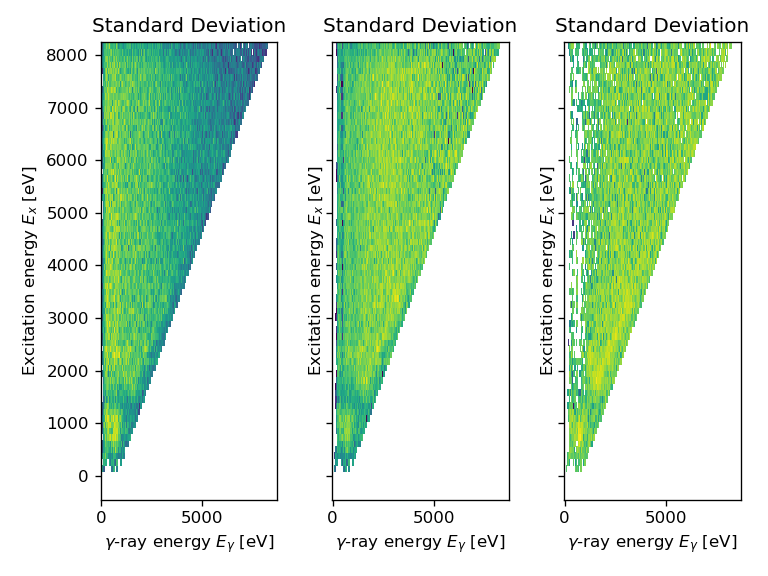

In [66]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()